In [1]:
# import all required modules 
import pyvisa
import visa
import logging
import sys
import time
from pprint import pprint
import json
import wavedrom
from quantiphy import Quantity as QE
import matplotlib.pyplot as plt
from datetime import datetime
import rigol1000z as Rigol1000z
from IPython.display import Image
from matplotlib.ticker import EngFormatter

# https://www.keysight.com/upload/cmc_upload/All/programming_guide_english.pdf

In [2]:
# ========== Configuration Section ==========
conn_str = 'GPIB0::17::INSTR'
rigol_Conn_Str = "USB0::0x1AB1::0x04CE::DS1ZB165251691::INSTR"
SMU_1 = 2
SMU_2 = 3
SMU_3 = 4
SMU_4 = 5

vdd_v = 1
formatter1 = EngFormatter(places=2, sep="")
SimulationTime = -1

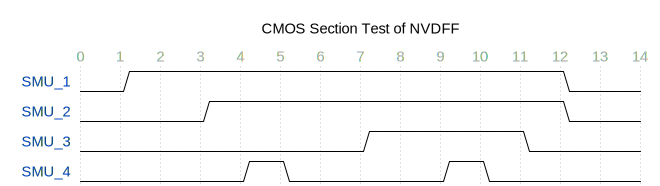

In [3]:
# Waveform Generator 
tick_time = QE('50ns')
waveform_json = """
{"signal": [
 {"name": "SMU_1", "wave": "01..........0."},
 {"name": "SMU_2", "wave": "0..1........0."},
 {"name": "SMU_3", "wave": "0......1...0.."},
 {"name": "SMU_4", "wave": "0...10...10..."}
],
 "head":{
 "text":"CMOS Section Test of NVDFF",
 "tick":0
}}
"""
wavedrom.render(waveform_json)

In [4]:
def screenshot(file_suff):
    rm = visa.ResourceManager()
    res = rm.list_resources()
    #print( res )
    ins = rm.get_instrument( res[0] ) # !

    ins.write(":DISP:DATA?")
    bmpdata = ins.read_raw()[2+9:]

    ins.close()

    # save image file
    name = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    print("Enter a filename-safe description (or none). Hit return.")
    comment = file_suff
    if( len(comment) ):
        name = name + "_" + comment

    try:
        from PIL import Image

    except ImportError as e:
        print("PIL(low) not imported because:", e)
        filename = name + ".png"
        print("Saving screen as", filename)
        with open( filename, "wb") as f:
            f.write( bmpdata )
    return filename

def parse_wave_seq(seq, tick):
    if set(seq).difference({'.', '0', '1'}):
        raise Exception("Invalid charater in sequence")
        return
    if tick> len(seq):
        raise Exception("Tick is out of sequence")
        return 
    while(seq[tick] == "."):
        tick = tick-1 
        pass
    return float(seq[tick])
waveform = {}
for each in json.loads(waveform_json)["signal"]:
    waveform[each["name"]] = each["wave"]
SimulationTime = len(waveform[list(waveform.keys())[0]]) if SimulationTime == -1 else SimulationTime
print(f"Simulating for {SimulationTime} Ticks")

Simulating for 14 Ticks


In [5]:
# Setting up PyVISA interface
rm = pyvisa.ResourceManager()
dev_list = rm.list_resources()
if conn_str not in dev_list:
    print(f"Device {conn_str} not found")
    exit(1)
    
# Setting up B1500 
inst = rm.open_resource(conn_str)
device_name = inst.query("*IDN?")
inst.write("*RST")  # Reset B1500 to initial state
inst.write("FMT 1")  # Set IO Format
print(f"Connected to {device_name}")

# Clear All the channels to simulate
inst.write(f"CL {SMU_1},{SMU_2},{SMU_3},{SMU_4}")
inst.write(f"CN {SMU_1},{SMU_2},{SMU_3},{SMU_4}")  

Connected to Agilent Technologies,B1500A,0,A.06.01.2016.0401



(12, <StatusCode.success: 0>)

In [6]:
# Setting Up RIGOl 1074 Oscilloscope
osc_resource = rm.open_resource(rm.list_resources()[0])
osc = Rigol1000z.Rigol1000z(osc_resource)
osc.timebase.set_timebase_scale_s_div(50E-3)
osc.trigger.set_trigger_level_V(0.5)
for i in 1,2,3,4:
    osc[i].set_vertical_scale_V(1)
    osc[i].set_probe_ratio(1)
    osc[i].visa_write(':disp 1')
    osc.visa_write(":chan%d:OFFSet %.2f"%(i,(i*2)-6))
    osc.visa_write(":MEASure:ITEM VMAX,CHANnel%d"%i)
    

Enter a filename-safe description (or none). Hit return.
PIL(low) not imported because: No module named 'PIL'
Saving screen as 2019-10-28_11-44-21_TestDSOConn.png


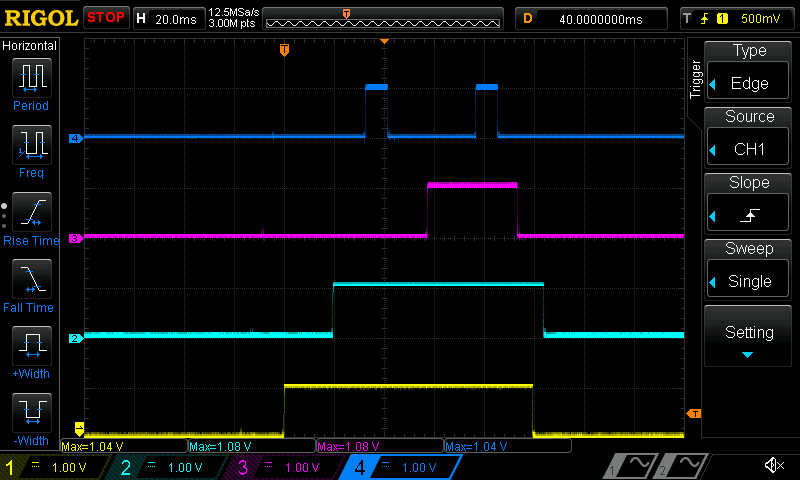

In [7]:
# Clear All the channels to simulate Final DFF Output
inst.write(f"CL {SMU_1},{SMU_2},{SMU_3},{SMU_4}")
inst.write(f"CN {SMU_1},{SMU_2},{SMU_3},{SMU_4}") 

timebase = 20E-3
offset_blocks = 2.0 * timebase
osc.timebase.set_timebase_scale_s_div(timebase)
osc.visa_write(":TIMebase:MAIN:OFFSet %2E"%offset_blocks) 
osc.set_single_shot()
time.sleep(3)

comp_current = 100E-6
for i in range(SimulationTime):
    inst.write("DV %d,0,%.2f,%.2E"% (SMU_1, vdd_v*parse_wave_seq(waveform["SMU_1"], i), comp_current))
    inst.write("DV %d,0,%.2f,%.2E"% (SMU_2, vdd_v*parse_wave_seq(waveform["SMU_2"], i), comp_current))
    inst.write("DV %d,0,%.2f,%.2E"% (SMU_3, vdd_v*parse_wave_seq(waveform["SMU_3"], i), comp_current))
    inst.write("DV %d,0,%.2f,%.2E"% (SMU_4, vdd_v*parse_wave_seq(waveform["SMU_4"], i), comp_current))
    
time.sleep(1)
Image(filename=screenshot("TestDSOConn"))

## WGFMU Setup

In [60]:
# Clear All the channels to simulate Final DFF Output
inst.write(f"CL {SMU_1},{SMU_2},{SMU_3},{SMU_4}")
inst.write(f"CN {SMU_1},{SMU_2},{SMU_3},{SMU_4}") 

# Setup Variables
comp_current = 100E-6
WChan1 = 2
timebase = 50E-3
offset_blocks = 0 * timebase

# Setup configuration os DSO
osc.visa_write(":TRIGger:EDGe:SOURce CHANnel1")
osc.timebase.set_timebase_scale_s_div(timebase)
osc.visa_write(":TIMebase:MAIN:OFFSet %2E"%offset_blocks) 
osc.set_single_shot()
time.sleep(3)

inst.write(f"CL {WChan1}")
inst.write(f"CN {WChan1}") 

inst.write("FMT 0,2")
inst.write(f"PV {WChan1},0,0,1,1E-3")
inst.write("PT 0.1,0.01,0.02")
inst.write(f"MM 3,{WChan1}")
inst.write("TSR")

# Assert VDD
inst.write("DV %d,0,%.2f,%.2E"% (SMU_3, 1, comp_current))
# Start Pulse Measurement
inst.write("XE")
# Turn off VDD
inst.write("DV %d,0,%.2f,%.2E"% (SMU_3, 0, comp_current))

inst.write("TSQ")
print(inst.query("ERR?"))

# Disable Channel
inst.write(f"CL {SMU_1},{SMU_2},{SMU_3},{SMU_4}")

time.sleep(0.50)
# Image(filename=screenshot("TestDSOConn"))

resultpt = inst.query("NUB?").strip()
print(f"Total {resultpt} pts available")
for i in range(int(resultpt)):
    r = inst.query("#,3A,12D,X").strip()
    print(r, QE(r[3:]))

100,100,120,0

Total 2 pts available
NBI+0.00095E-03 950n
NZT+1.59930E-01 159.93m
